# Setup Prerequisites

## Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-io
!pip install kafka-python
!pip install sklearn

     |████████████████████████████████| 23.1 MB 1.8 MB/s 
     |████████████████████████████████| 2.1 MB 40.5 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.22.0
    Uninstalling tensorflow-io-gcs-filesystem-0.22.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.22.0
     |████████████████████████████████| 246 kB 5.2 MB/s 


In [ ]:
import os
from datetime import datetime
import time
import threading
import json
from kafka import KafkaProducer
from kafka.errors import KafkaError
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio

#Importing the Libraries
import pandas as PD
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

In [ ]:
print("tensorflow-io version: {}".format(tfio.__version__))
print("tensorflow version: {}".format(tf.__version__))

tensorflow-io version: 0.23.1
tensorflow version: 2.7.0


## Kafka

In [ ]:
!curl -sSOL https://downloads.apache.org/kafka/2.7.2/kafka_2.13-2.7.2.tgz
!tar -xzf kafka_2.13-2.7.2.tgz

In [ ]:
!./kafka_2.13-2.7.2/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-2.7.2/config/zookeeper.properties
!./kafka_2.13-2.7.2/bin/kafka-server-start.sh -daemon ./kafka_2.13-2.7.2/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [ ]:
!ps -ef | grep kafka

root         652       1 15 12:57 ?        00:00:02 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-2.7.2/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-2.7.2/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-2.7.2/bin/../config/log4j.properties -cp /content/kafka_2.13-2.7.2/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-2.7.2/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-2.7.2/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-2.7.2/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-2.7.2/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-2.7.2/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13

In [ ]:
!./kafka_2.13-2.7.2/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic stock

Created topic stock.


In [ ]:
!./kafka_2.13-2.7.2/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic stock

Topic: stock	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: stock	Partition: 0	Leader: 0	Replicas: 0	Isr: 0


# Dataset

In [ ]:
COLUMNS = [
           'Date',
           'Symbol',
           'Year',
           'Month',
           'Day',
           'Open',
           'High',
           'Low',
           'Close',
           'A.C',
           'Volume',
           'D.A',
           'S.C'
           ]
features = ['Open', 'High', 'Low', 'Volume']
NUM_COLUMNS = len(COLUMNS) - 9

In [ ]:
stock_iterator = pd.read_csv('/content/drive/MyDrive/BigDataTest/TELA.csv', header=0, names=COLUMNS, chunksize=100000)
stock_df = next(stock_iterator)
stock_df = stock_df.iloc[::-1]
stock_df.head()

,Date,Symbol,Year,Month,Day,Open,High,Low,Close,A.C,Volume,D.A,S.C
5271,8-12-2000 00:00:00,TELA,2000,12,8,15.81,22.88,15.13,20.00,5.343783,8574900.0,0.0,1.0
5270,11-12-2000 00:00:00,TELA,2000,12,11,22.69,22.75,19.88,21.19,5.661738,1459600.0,0.0,1.0
5269,12-12-2000 00:00:00,TELA,2000,12,12,21.22,21.25,19.38,19.88,5.311720,538700.0,0.0,1.0
5268,13-12-2000 00:00:00,TELA,2000,12,13,20.75,20.88,19.75,19.88,5.311720,211200.0,0.0,1.0
5267,14-12-2000 00:00:00,TELA,2000,12,14,19.98,20.25,19.88,20.13,5.378517,132700.0,0.0,1.0


In [ ]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(stock_df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=stock_df.index)
feature_transform.head()

,Open,High,Low,Volume
5271,0.007981,0.051003,0.014921,0.318930
5270,0.049899,0.050211,0.044087,0.053926
5269,0.040943,0.041082,0.041017,0.019628
5268,0.038080,0.038830,0.043289,0.007430
5267,0.033388,0.034996,0.044087,0.004507


In [ ]:
# Number of datapoints and columns
len(stock_df), len(stock_df.columns)

(5272, 13)

In [ ]:
# Có thể drop tiếp các x_df nếu không muốn sử dụng thêm một số feature, tuy nhiên
# cần phải sửa lại mô hình
# x_df = stock_df.drop(["Date", "Symbol", "Year", "Month", "Day", "D.A", "S.C"], axis=1)
x_df = feature_transform
# Không cần để ý y_df
y_df = stock_df[["Year", "Month", "Day", "A.C"]]

In [ ]:
x_list = list(filter(None, x_df.to_csv(index=False).split("\n")[1:]))
y_list = list(filter(None, y_df.to_csv(index=False).split("\n")[1:]))

# Write to Kafka

In [ ]:
def error_callback(exc):
    raise Exception('Error while sendig data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, items):
  count=0
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  for message, key in items:
    producer.send(topic_name, key=key.encode('utf-8'), value=message.encode('utf-8')).add_errback(error_callback)
    count+=1
  producer.flush()
  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

write_to_kafka("stock", [(x_list[i], y_list[i]) for i in range(len(x_list))])

Wrote 5272 messages into topic: stock


# Get messages from Kafka

In [ ]:
train_ds = tfio.IODataset.from_kafka('stock', partition=0, offset=0)

In [ ]:
counter = 0
train = []
label = []
for x in train_ds:
  if counter == 0:
    counter += 1
    continue
  a = tf.io.decode_csv(x.message, [[0.0] for i in range(NUM_COLUMNS)])
  b = tf.io.decode_csv(x.key, [[0.0] for i in range(NUM_COLUMNS)])
  a =  tf.reshape(a, (1, 4), name=None)
  b = tf.reshape(b[3], (1, 1), name=None)
  train.append(a)
  label.append(b)

# Train model

## Split data

In [ ]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=8)
for train_index, test_index in timesplit.split(train):
        X_train_list, X_test_list = train[:len(train_index)], train[len(train_index): (len(train_index)+len(test_index))]
        y_train_list, y_test_list = label[:len(train_index)], label[len(train_index): (len(train_index)+len(test_index))]     

In [ ]:
X_train = tf.convert_to_tensor(X_train_list, dtype=None, dtype_hint=None, name=None)
y_train = tf.convert_to_tensor(y_train_list, dtype=None, dtype_hint=None, name=None)
X_test = tf.convert_to_tensor(X_test_list, dtype=None, dtype_hint=None, name=None)
y_test = tf.convert_to_tensor(y_test_list, dtype=None, dtype_hint=None, name=None)

## Model

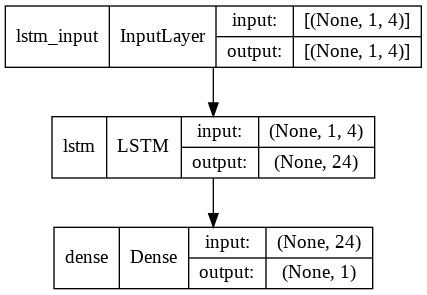

In [ ]:
#Building the LSTM Model
# Có thể thử nghiệm thêm về các mô hình mạng khác
lstm = Sequential()
# Chú ý về input shape cần thay đổi
lstm.add(LSTM(24, input_shape=(1, 4), activation='softmax', return_sequences=False))
lstm.add(Dense(1, activation='relu'))
# lstm.build()
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

## Training

In [ ]:
# Cần thay đổi batch_size để học tốt hơn, batch size càng nhỏ học càng tốt và kết quả sẽ tốt hơn, nhỏ quá sẽ bị overfit
history=lstm.fit(X_train, y_train, epochs=300, verbose=1, shuffle=False)

Epoch 1/300
147/147 [==============================] - 0s 2ms/step - loss: 1077.1406
Epoch 2/300
147/147 [==============================] - 0s 3ms/step - loss: 1077.1406
Epoch 3/300
147/147 [==============================] - 0s 3ms/step - loss: 1077.1406
Epoch 4/300
147/147 [==============================] - 0s 2ms/step - loss: 1077.1406
Epoch 5/300
147/147 [==============================] - 0s 3ms/step - loss: 1077.1406
Epoch 6/300
147/147 [==============================] - 0s 3ms/step - loss: 1077.1406
Epoch 7/300
147/147 [==============================] - 0s 2ms/step - loss: 1077.1406
Epoch 8/300
147/147 [==============================] - 0s 2ms/step - loss: 1077.1406
Epoch 9/300
147/147 [==============================] - 0s 2ms/step - loss: 1077.1406
Epoch 10/300
147/147 [==============================] - 0s 2ms/step - loss: 1077.1406
Epoch 11/300
  1/147 [..............................] - ETA: 0s - loss: 5783.8320

KeyboardInterrupt: ignored

## Testing and visualize

In [ ]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

In [ ]:
pred = []
for y in y_pred:
  pred.append(y[0])
  
true = []
for y in y_test:
  true.append(y[0][0])

In [ ]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(list(true), label='True Value')
plt.plot(list(pred), label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()